In [10]:
from __future__ import annotations

import sys
import traceback
from pathlib import Path
from typing import Any, List

import numpy as np
import pandas as pd  # type: ignore[import]

In [11]:
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_ROOT = PROJECT_ROOT / "src"
DATA_ROOT = PROJECT_ROOT / "data" / "processed"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_ROOT}")

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data directory: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed


In [12]:
from src.Bayesian_state.problems import StateModel  # type: ignore[import]
from src.Bayesian_state.utils.load_config import MODEL_STRUCT  # type: ignore[import]

print(f"Available model structures: {list(MODEL_STRUCT.keys())}")

ImportError: cannot import name 'StateModel' from partially initialized module 'src.Bayesian_state.problems' (most likely due to a circular import) (D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\src\Bayesian_state\problems\__init__.py)

In [ ]:
def build_subject_dataset(subject_id: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """Load Task2 data and return arrays for a single subject."""
    task2_path = DATA_ROOT / "Task2_processed.csv"
    if not task2_path.exists():
        raise FileNotFoundError(f"Missing processed dataset: {task2_path}")

    learning_data = pd.read_csv(task2_path)
    subject_data = learning_data[learning_data["iSub"] == subject_id]
    if subject_data.empty:
        raise ValueError(f"Subject {subject_id} not found in Task2 dataset")

    condition = int(subject_data["condition"].iloc[0])
    stimulus = subject_data[["feature1", "feature2", "feature3", "feature4"]].to_numpy(dtype=float)
    choices = subject_data["choice"].to_numpy(dtype=float)
    feedback = subject_data["feedback"].to_numpy(dtype=float)

    return stimulus, choices, feedback, condition


def make_trial_sequence(stimulus: np.ndarray, choices: np.ndarray, feedback: np.ndarray, max_trials: int = 20) -> List[List[Any]]:
    """Assemble the per-trial list expected by StateModel.fit_step_by_step."""
    usable = min(len(stimulus), max_trials)
    trials: List[List[Any]] = []
    for idx in range(usable):
        trial: List[Any] = [stimulus[idx], int(choices[idx]), float(feedback[idx])]
        trials.append(trial)
    return trials

In [ ]:
subject_id = 15

try:
    stimulus, choices, feedback, condition = build_subject_dataset(subject_id)
except Exception as exc:  # noqa: BLE001
    print("Dataset preparation failed:", exc)
    traceback.print_exc()
    raise

print(f"Loaded subject {subject_id} with {len(stimulus)} trials (condition {condition}).")
print("First stimulus row:", stimulus[0])
print("Choice / feedback samples:", choices[:3], feedback[:3])

Loaded subject 15 with 384 trials (condition 3).
First stimulus row: [0.22878328 0.73217257 0.38135291 0.20531656]
Choice / feedback samples: [3. 3. 3.] [0. 0. 1.]


In [ ]:
from copy import deepcopy

model_choice = "pm_model"


engine_config = deepcopy(MODEL_STRUCT.get(model_choice))

if engine_config is None:
    raise KeyError(f"{model_choice} configuration not found in MODEL_STRUCT")

# DEBUG CONFIG
hypo_debug = True
if "modules" in engine_config and "hypo_transitions_mod" in engine_config["modules"]:
    engine_config["modules"]["hypo_transitions_mod"]["kwargs"]['hypothesis_debug'] = hypo_debug

try:
    model = StateModel(
        engine_config,
        condition=condition,
        subject_id=subject_id,
        processed_data_dir=DATA_ROOT,
    )
except Exception as exc:
    print("StateModel construction failed:", exc)
    traceback.print_exc()
    raise

print("StateModel initialised successfully.")

INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.


{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.7}}, 'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule', 'kwargs': {'mean': [-0.008987819671576303, -0.0013484044997005968, -0.011365922117348408, 0.003650995494801886], 'std': [0.04239360199674432, 0.042689185630535434, 0.03891249493377415, 0.017350713684618067], 'subject_id': 15}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.7}
name: perception_mod mod_kwargs: {'mean': [-0.008987819671576303, -0.0013484044997005968, -0.011365922117348408, 0.003650995494801886], 'std': [0.04239360199674432, 0.042689185630535434, 0.03891249493377415, 0.017350713684618067], 'subject_id': 15}
StateModel initialised successfully.


In [8]:
trial_sequence = make_trial_sequence(stimulus, choices, feedback, max_trials=100000)
print(f"Prepared {len(trial_sequence)} trials for inference.")
print("Example trial:", trial_sequence[0])

NameError: name 'make_trial_sequence' is not defined

In [7]:
print(model.engine.perception.mean)

NameError: name 'model' is not defined

In [ ]:
try:
    posterior_log = model.fit_step_by_step(trial_sequence)
except Exception as exc:
    print("fit_step_by_step raised an exception:", exc)
    traceback.print_exc()
    raise

if not posterior_log:
    raise RuntimeError("fit_step_by_step returned no posterior entries")

last_post = posterior_log[-1]
if not isinstance(last_post, np.ndarray):
    raise TypeError(f"Posterior entries are not numpy arrays as expected (got {type(last_post)})")

print(f"Posterior length: {len(last_post)}")
print(f"Posterior sum: {last_post.sum():.6f}")

Posterior length: 116
Posterior sum: 1.000000


In [ ]:
# 打印 posterior 最大的 5 个 hypo index
post_sum_hypo = np.sum(posterior_log, axis=0)
top5_indices = np.argsort(post_sum_hypo)[-5:][::-1]
top5_indices

array([ 42,  94, 106,  48,  55])

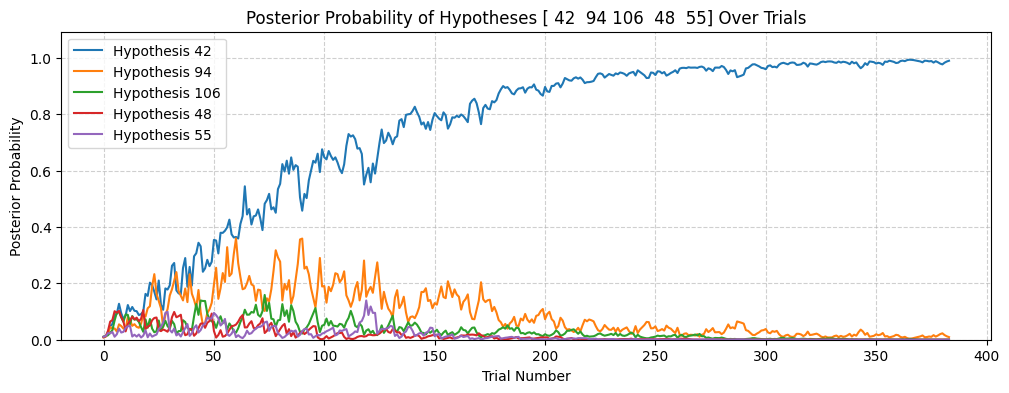

In [ ]:
# 画图

import matplotlib.pyplot as plt

def plot_hypo_posterior(posterior_log: list, hypo_indices: list, title: str = None):
    
    plt.figure(figsize=(12, 4))
    
    max_post_overall = 0
    
    # 遍历所有需要绘制的 hypothesis index
    for hypo_index in hypo_indices:
        hypo_posterior_over_time = [posterior[hypo_index] for posterior in posterior_log]
        
        # 找到所有曲线中的最大值，以统一y轴
        max_post = max(hypo_posterior_over_time)
        if max_post > max_post_overall:
            max_post_overall = max_post

        trials = np.arange(len(hypo_posterior_over_time))
        plt.plot(trials, hypo_posterior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')
    
    if title is None:
        title = f'Posterior Probability of Hypotheses {hypo_indices} Over Trials'
    plt.title(title)
    plt.xlabel('Trial Number')
    plt.ylabel('Posterior Probability')
    plt.ylim(0, max_post_overall * 1.1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()


hypo_indices = top5_indices
plot_hypo_posterior(posterior_log, hypo_indices=hypo_indices)